# Applying Solution to Simplified, Small Scale Streets Data

We will use a small area around the center of the town of middleton

(Lat, long) of middleton depot is (43.095273490280036, -89.50918121778929)

In [272]:
import networkx as nx
import geopandas as gpd
import momepy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import osmnx as ox
import shapely

In [273]:
point = (43.095273490280036, -89.50918121778929)
G = ox.graph_from_point(point, dist=500, network_type='drive')


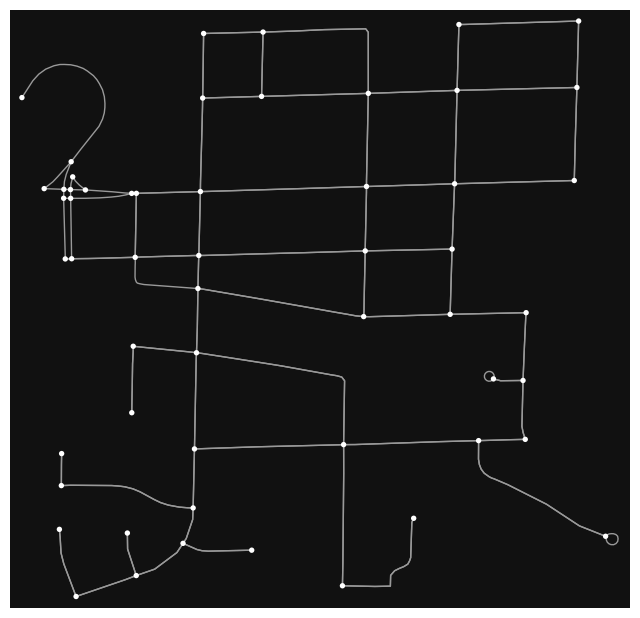

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [274]:
ox.plot_graph(G)

In [275]:
print(G)
print(nx.is_strongly_connected(G))

MultiDiGraph with 55 nodes and 134 edges
False


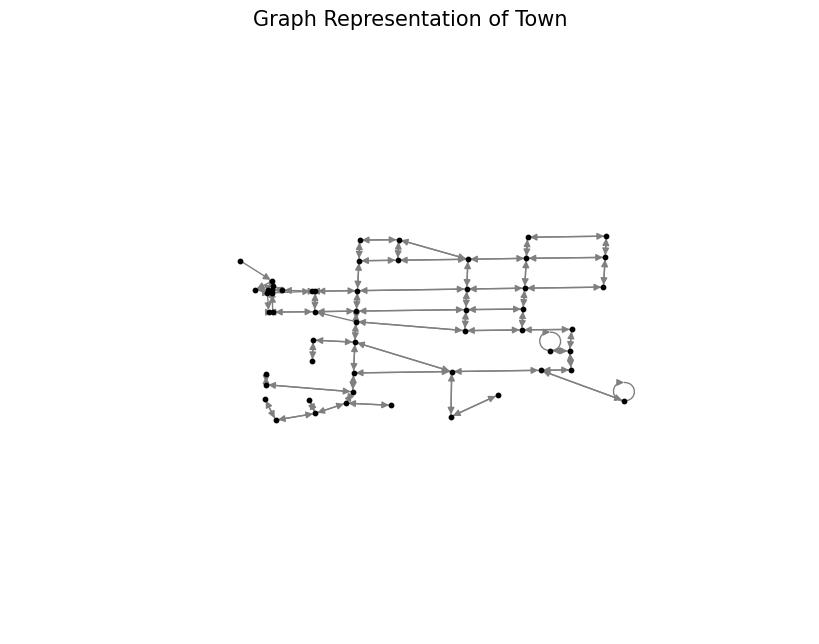

In [276]:
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G.nodes(data=True)}
plt.figure(figsize=(8, 6))
nx.draw(G, pos=node_positions, node_size=10, node_color='black', edge_color='gray', with_labels=False)
plt.title('Graph Representation of Town', size=15)
plt.show()

Remove all but the largest strongly connected component

In [277]:
G_strong = G.copy()
scc = list(nx.strongly_connected_components(G)) # strongly connected components
scc.remove(max(scc, key=len))

for i in scc:
    for j in i:
        G_strong.remove_node(j) # remove all but the strongest connected component from G
print(nx.is_strongly_connected(G_strong))

True


Plot

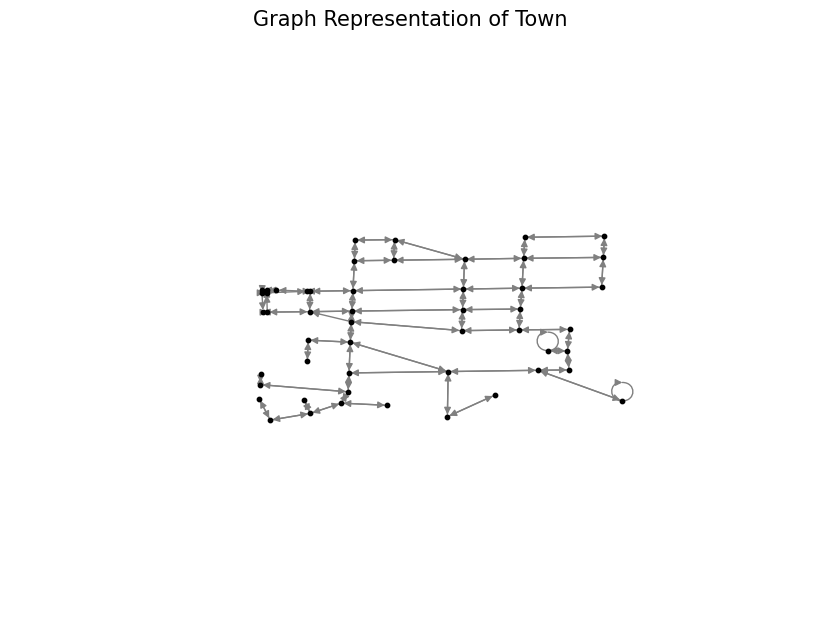

In [278]:
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G_strong.nodes(data=True)}
plt.figure(figsize=(8, 6))
nx.draw(G_strong, pos=node_positions, node_size=10, node_color='black', edge_color='gray', with_labels=False)
plt.title('Graph Representation of Town', size=15)
plt.show()

In [279]:
def print_graph_attributes(G, nodes=True, edges=True):
    if nodes:
        for node in G.nodes(data=True):
            print(node)
    if edges:
        for edge in G.edges(data=True, keys=True):
            print(edge)

## Add Graph Attributes

What additional attributes do I have in the actual data set? Jurisdiction (determine deadheading)

Add priorities, number of passes, salt required. Do it without converting to a geodataframe to avoid issues of Nonetypes in geometry when converting back.

In [280]:
priority_keys = {"residential":1, "tertiary":2, "motorway_link":3, "primary":4}
passes_keys = {"residential":1, "tertiary":1, "motorway_link":2, "primary":2}
salt_keys = {"residential":1, "tertiary":1, "motorway_link":2, "primary":3}


# go through each edge and update dictionary
for edge in G_strong.edges(data=True, keys=True):
    attrb = edge[3]
    highway_type = attrb['highway']
    attrb['priority'] = priority_keys[highway_type]
    if 'lanes' in attrb:
        attrb['passes_rem'] = float(attrb['lanes']) // 2
        attrb['salt_per'] = float(attrb['lanes']) // 2
    else:
        attrb['passes_rem'] = passes_keys[highway_type]
        attrb['salt_per'] = passes_keys[highway_type]

Add node information

Update the effective degree of all nodes. If $v$ is the vertice and $E_v$ is the set of all edges leaving from $v$, then the effective degree is 
$$\text{Deg(v)} = \sum_{e \in E_v} e(\text{passes})$$

Also, calculate the weighted degree of each node, defined as
$$\text{WeightedDeg(v)} = \sum_{e \in E_v} e(\text{passes})\cdot e(\text{priority})$$

Also, update the total amount of salting required for the road given the number of passes

In [281]:
def config_graph_attributes(G):
    for node in G.nodes:
        weight_deg = 0
        for edge in G.edges([node], data=True):
            weight_deg += edge[2]['passes_rem']*edge[2]['priority']
        G.nodes[node]['weighted_degree'] = weight_deg
    # add a new attribute to each edge, called "deadheading_passes" and initially set to 0
    for edge in G.edges(data=True):
        edge[2]['deadheading_passes'] = 0


config_graph_attributes(G_strong)
# print result
for node in G_strong.nodes(data=True):
    print(node)

(38408843, {'y': 43.0967641, 'x': -89.5140532, 'highway': 'traffic_signals', 'street_count': 4, 'weighted_degree': 14})
(53303114, {'y': 43.0968915, 'x': -89.5141858, 'highway': 'traffic_signals', 'street_count': 4, 'weighted_degree': 6})
(53413369, {'y': 43.095146, 'x': -89.505227, 'street_count': 3, 'weighted_degree': 2})
(53413372, {'y': 43.095123, 'x': -89.506699, 'street_count': 3, 'weighted_degree': 3})
(53413374, {'y': 43.0950908, 'x': -89.508375, 'street_count': 3, 'weighted_degree': 3})
(53413399, {'y': 43.0954878, 'x': -89.5115872, 'street_count': 4, 'weighted_degree': 4})
(53424379, {'y': 43.094579, 'x': -89.511615, 'street_count': 4, 'weighted_degree': 4})
(53424384, {'y': 43.094671, 'x': -89.512841, 'street_count': 3, 'weighted_degree': 2})
(53441503, {'y': 43.0960203, 'x': -89.508345, 'street_count': 4, 'weighted_degree': 6})
(53441511, {'y': 43.0959556, 'x': -89.51157, 'highway': 'stop', 'street_count': 4, 'weighted_degree': 7})
(53441514, {'y': 43.0959296, 'x': -89.5128

In [282]:
nodes, edges = ox.graph_to_gdfs(G_strong) # better than momepy b/c fills in missing geometry attributes

In [283]:
print(G_strong)

G_strong = ox.graph_from_gdfs(nodes, edges) # add linestring attributes

print_graph_attributes(G_strong)

MultiDiGraph with 51 nodes and 128 edges
(38408843, {'y': 43.0967641, 'x': -89.5140532, 'highway': 'traffic_signals', 'street_count': 4, 'weighted_degree': 14.0})
(441028477, {'y': 43.096888, 'x': -89.5140567, 'highway': 'traffic_signals', 'street_count': 4, 'weighted_degree': 8.0})
(53475938, {'y': 43.0968342, 'x': -89.5128708, 'street_count': 3, 'weighted_degree': 16.0})
(53303114, {'y': 43.0968915, 'x': -89.5141858, 'highway': 'traffic_signals', 'street_count': 4, 'weighted_degree': 6.0})
(452225415, {'y': 43.096765, 'x': -89.5141895, 'highway': 'traffic_signals', 'street_count': 4, 'weighted_degree': 9.0})
(53413369, {'y': 43.095146, 'x': -89.505227, 'street_count': 3, 'weighted_degree': 2.0})
(53413372, {'y': 43.095123, 'x': -89.506699, 'street_count': 3, 'weighted_degree': 3.0})
(53664849, {'y': 43.0941869, 'x': -89.505287, 'street_count': 3, 'weighted_degree': 3.0})
(53413374, {'y': 43.0950908, 'x': -89.508375, 'street_count': 3, 'weighted_degree': 3.0})
(53673210, {'y': 43.0960

## Creating the Dual Graph
#### Determining the Angle Between Two Linestrings

Determining the angle between two linestrings. There are two approaches: endpoints vs. closest coords. Closest coords is the best approach, but momepy uses endpoints

In [284]:
from math import atan2
from math import pi

def angle(a, b, c):
    '''
    Calculates the signed angle in degrees between vectors ab and bc. Negative if bc is clockwise of ab.
    '''
    v = (b[0]-a[0], b[1]-a[1])
    w = (c[0]-b[0], c[1]-b[1])

    dot = v[0]*w[0] + v[1]*w[1]     # Dot product between [x1, y1] and [x2, y2]
    det = v[0]*w[1] - v[1]*w[0]      # Determinant
    angle = atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

    return angle*180/pi

In [285]:
def turn_direction(angle):
    '''
    Returns the direction of a turn given an angle. Clockwise (right turn) angles are negative, counterclockwise are positive
    '''
    if angle < 15 and angle > -15:
        return "straight"
    elif angle >= -90 and angle <= -15:
        return "right"
    elif angle >= -135 and angle < -90:
        return "sharp right"
    elif angle <= 90 and angle >= 15:
        return "left"
    elif angle <= 135 and angle > 90:
        return "sharp left"
    else:
        return "u-turn"

Note that plotting scales are disconfigured

-88.5576471686895
right


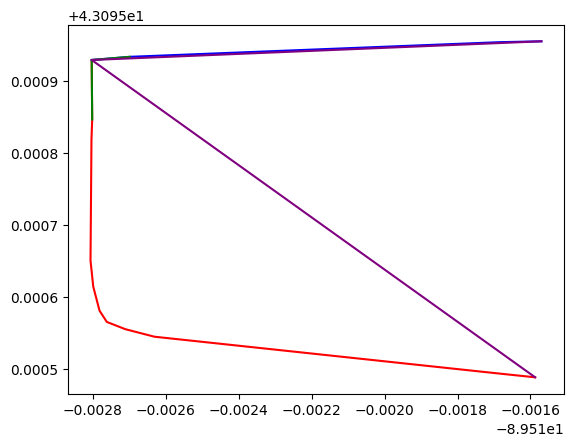

In [286]:
from_node = (53413399, 53441514)
to_node = (53441514, 53441511)
# get the edge associated with the two indices in from_node
testL1 = G.edges[from_node[0], from_node[1], 0]['geometry']
testL2 = G.edges[to_node[0], to_node[1], 0]['geometry']

p0 = testL1.coords[-2]
p1 = testL1.coords[-1]

p2 = testL2.coords[0]
p3 = testL2.coords[1]

p0_endpoint = testL1.coords[0]
p3_endpoint = testL2.coords[-1]

plt.plot(*testL1.xy, color='red')
plt.plot(*testL2.xy, color='blue')
plt.plot(*shapely.geometry.LineString([p0, p1, p2, p3]).xy, color='green') # green is much better
plt.plot(*shapely.geometry.LineString([p0_endpoint, p1, p2, p3_endpoint]).xy, color='purple')

points = [p0, p1, p2, p3]

shared = [x for x in points if points.count(x) > 1]
remaining = [e for e in points if e not in [shared[0]]]
angle_value = angle(remaining[0], shared[0], remaining[1])
print(angle_value)
print(turn_direction(angle_value))

As we can see, the green is a lot better approximation of the angle.

Furthermore, this method allows us to compute angles between self-loops, whereas Momepy fails here. However, this next example is really a u-turn in a cul-de-sac. Therefore, for self-loops, we set the angle to 180 degrees by hand

{0: {'osmid': 6763942, 'name': 'Henry Court', 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': 46.884, 'geometry': <LINESTRING (-89.505 43.094, -89.506 43.094, -89.506 43.094)>}}
{0: {'osmid': 405907623, 'oneway': True, 'name': 'Henry Court', 'highway': 'residential', 'reversed': False, 'length': 48.30500000000001, 'geometry': <LINESTRING (-89.506 43.094, -89.506 43.094, -89.506 43.094, -89.506 43.094,...>}}
(43.094183, -89.5057213) 
 (43.0942089, -89.5058599) 
 (43.0942344, -89.5058469)
array('d', [-89.505287, -89.5057213, -89.5058599]) array('d', [43.0941869, 43.094183, 43.0942089])
(-89.5057213, 43.094183) (-89.5058599, 43.0942089) (-89.5058469, 43.0942344)
-106.4279571919852
sharp right


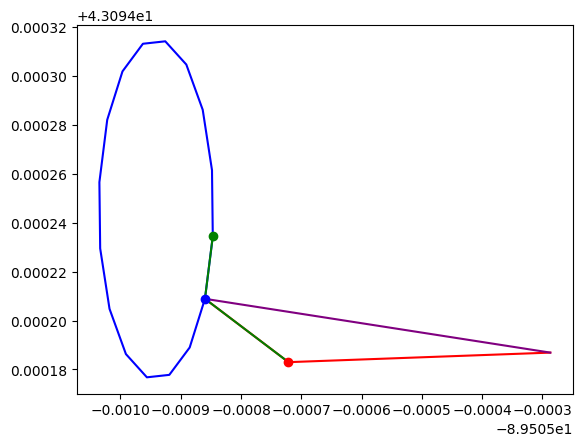

In [287]:
from_node = (53664849, 53664854)
to_node = (53664854, 53664854)
print(G[from_node[0]][from_node[1]]) #henry crt to henry st
print(G[to_node[0]][to_node[1]]) # henry ctr to henry crt (self loop) should be u-turns

# get the edge associated with the two indices in from_node
testL1 = G.edges[from_node[0], from_node[1], 0]['geometry']
testL2 = G.edges[to_node[0], to_node[1], 0]['geometry']

p0 = testL1.coords[-2]
p1 = testL1.coords[-1]

p2 = testL2.coords[0]
p3 = testL2.coords[1]

print(p0[::-1], "\n", p1[::-1], "\n", p3[::-1])
p0_endpoint = testL1.coords[0]
p3_endpoint = testL2.coords[-1]
print(*testL1.xy)
plt.plot(*testL1.xy, color='red')
plt.plot(*testL2.xy, color='blue')
plt.plot(*shapely.geometry.LineString([p0, p1, p2, p3]).xy, color='green') # green is much better
plt.plot(*shapely.geometry.LineString([p0_endpoint, p1, p2, p3_endpoint]).xy, color='purple')

points = [p0, p1, p2, p3]

shared = [x for x in points if points.count(x) > 1]
remaining = [e for e in points if e not in [shared[0]]]
plt.plot(*remaining[0], 'ro')
plt.plot(*shared[0], 'bo')
plt.plot(*remaining[1], 'go')
print(remaining[0], shared[0], remaining[1])
angle_value = angle(remaining[0], shared[0], remaining[1])
print(angle_value)
print(turn_direction(angle_value))

The graph is distorted from reality, but the turn is in actuality sharp right.

In [288]:
def cost_of_dual_node(n1, n2, angle):
    """
    Calculate the weighted degree of a node in a graph. Helper for ``create_dual``.
    """
    weight= n1[3]['length'] + n2[3]['length']
    # add the turn penalty cost
    turn_penalty = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}
    
    weight += turn_penalty[turn_direction(angle)]
    return weight

In [289]:
def create_dual(G: nx.MultiDiGraph):
    L = nx.MultiDiGraph()

    # Create a graph specific edge function.
    for from_node in G.edges(keys=True, data=True):
        # from_node is: (u,v,key, attrb)
        L.add_node(from_node[:3])
        for to_node in G.edges(from_node[1], keys=True, data=True):
            L.add_edge(from_node[:3], to_node[:3])
            # self loop means a u-turn is needed
            if(to_node[0] == to_node[1]):
                L.edges[from_node[:3], to_node[:3], 0]['angle'] = 180
                continue
                
            # add angles
            testL1 = from_node[3]['geometry']
            testL2 = to_node[3]['geometry']

            p0 = testL1.coords[-2]
            p1 = testL1.coords[-1]

            p2 = testL2.coords[0]
            p3 = testL2.coords[1]

            
            points = [p0, p1, p2, p3]
            shared = [x for x in points if points.count(x) > 1]
            remaining = [e for e in points if e not in [shared[0]]]
            angle_value = angle(remaining[0], shared[0], remaining[1])

            L.edges[from_node[:3], to_node[:3], 0]['weight'] = cost_of_dual_node(from_node, to_node, angle_value)

    # add source and target nodes
    for node in G:
        L.add_node(str(node) + "_source", weight=0)
    # add edges connecting source and targets to valid gateways
    for node in L.nodes():
        # skip the source nodes which are strings. The other nodes are tuples
        if (type(node) == str):
            continue
            
        # for a digraph, not a multigraph:
        # source -> first node
        # second node -> source
        L.add_edge(str(node[0]) + "_source", node, weight=0)
        # L.add_edge(str(node[1]) + "_source", node, weight=0) only for undirected

        # L.add_edge(node, str(node[0]) + "_source", weight=0) only for undirected
        L.add_edge(node, str(node[1]) + "_source", weight=0)

    return L

In [290]:
G_dual = create_dual(G_strong)
print(G_dual)
print_graph_attributes(G_dual, nodes=False)

"""
Testing
node1 = 38408843
node2 = 441028477
node3 = 53303114
node4 = 452225415

nx.dijkstra_path(G_dual, (node1, node2, 0), (node3, node4, 0))"""

MultiDiGraph with 179 nodes and 626 edges
((38408843, 441028477, 0), (441028477, 53303114, 0), 0, {'weight': 26.269})
((38408843, 441028477, 0), '441028477_source', 0, {'weight': 0})
((441028477, 53303114, 0), (53303114, 452225415, 0), 0, {'weight': 26.558})
((441028477, 53303114, 0), '53303114_source', 0, {'weight': 0})
((38408843, 53475938, 0), (53475938, 452225119, 0), 0, {'weight': 173.64100000000002})
((38408843, 53475938, 0), (53475938, 3399247711, 0), 0, {'weight': 104.01700000000001})
((38408843, 53475938, 0), '53475938_source', 0, {'weight': 0})
((53475938, 452225119, 0), (452225119, 441028477, 0), 0, {'weight': 96.502})
((53475938, 452225119, 0), '452225119_source', 0, {'weight': 0})
((53475938, 3399247711, 0), (3399247711, 53441514, 0), 0, {'weight': 110.07300000000002})
((53475938, 3399247711, 0), (3399247711, 53475938, 0), 0, {'weight': 18.78})
((53475938, 3399247711, 0), (3399247711, 53453776, 0), 0, {'weight': 108.18299999999999})
((53475938, 3399247711, 0), '3399247711_

'\nTesting\nnode1 = 38408843\nnode2 = 441028477\nnode3 = 53303114\nnode4 = 452225415\n\nnx.dijkstra_path(G_dual, (node1, node2, 0), (node3, node4, 0))'

# Step 4: Route Construction Algorithm (RCA)

Variables:
| Variable | Definition 
|:--------:|:--------:|
|  RCL |  Restricted Candidate List |
|  $\alpha$   |  Threshold parameter. Value between 0 and 1  
|  C<sub>min   | Lowest incremental cost of a candidate element to be added to the partial solution    |
| C<sub>max | Highest incremental cost of a candidate element to be added to the partial solution|
| S_i | Amount of salt required to service road i |
|E| List of possible candidates that can be added to the partial solution
|No_Routes|Number of routes developed in the network



Overview:
1. If there is at least one required arc from the current node, then create a restricted candidate list based on the neighbors of the current node. Otherwise go to step 3
2. If RCL is empty, go to step 3. Otherwise choose a random arc from the RCL based on the threshold parameter and cost range
3. Go through the list of all required arcs and find the closest one.
4. Service that arc, subtracting one from the effective degree of the current node
5. Update the current node to the new node

## Defining a Class for the Routes

We want to keep track of certain attributes of each traversed edge for backtracking purposes. Let's create a class to manage all the variables

In [291]:
class RouteStep:
    """
    Represents a step in a route.

    Attributes:
        node1 (str): The starting node of the step.
        node2 (str): The ending node of the step.
        id (int): The id of the step (identifier for parallel edges)
        wasDeadheaded (bool): Indicates whether the step was a deadhead (empty) move.
        hadOptions (bool): Indicates whether the step had multiple options for routing. Could have gone a different direction
        saltval (int): Indicates the amount of salt the vehicle had before traversing the arc. Useful for checking validity of solution
    """
    def __init__(self, node1="", node2="", id=0, wasDeadheaded=False, hadOptions=False, saltval = 0):
        self.node1 = node1
        self.node2 = node2
        self.id = id
        self.wasDeadheaded = wasDeadheaded
        self.hadOptions = hadOptions
        self.saltval = saltval

    def __str__(self):
        return f"{self.node1} --> {self.node2}. ({self.id}) Deadhead: {self.wasDeadheaded}. Had options: {self.hadOptions}. Salt value: {self.saltval}"

    def __repr__(self):
        return str(self)


## Identifying Turn Directions at an Intersection - **No Modifications Required**

Methodology: Use coordinate system. Identify the three coordinates of the triangle (can be degenerate) that every turn makes. Potential for linear algebra: dot product of the two vectors, or change of basis?

Example: going from (2,1) to (0,1) to (-1,-1)

v = [-2, 0]
w = [-1, -2]

Create a function that computes the cost of traversing an arc

In [292]:
from math import atan2
from math import pi
def angle_vector(v, w):
    '''
    Computes the signed angle (in degrees) between two vectors v and w
    '''
    dot = v[0]*w[0] + v[1]*w[1]     # Dot product between [x1, y1] and [x2, y2]
    det = v[0]*w[1] - v[1]*w[0]      # Determinant
    angle = atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

    return angle*180/pi

In [293]:
def cost(G, prev, curr, nxt, k):
    '''
    Returns the cost of traversing an edge between two nodes. Based on distance and turn direction
    '''
    cost = G[curr][nxt][k]['length']

    # without previous node, we can't factor turn direction
    if prev is None:
        return cost
    
    # with a previous node, we incorporate turning penalites
    turn_cost = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}

    v_x = G.nodes[curr]['x']-G.nodes[prev]['x']
    v_y = G.nodes[curr]['y']-G.nodes[prev]['y']

    w_x = G.nodes[nxt]['x']-G.nodes[curr]['x']
    w_y = G.nodes[nxt]['y']-G.nodes[curr]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle_vector(v,w)
    cost += turn_cost[turn_direction(theta)]

    return cost

In [294]:
def needs_servicing(G, node1, node2, id):
    '''
    Returns whether or not the edge between two nodes requires servicing
    '''
    return G[node1][node2][id]['passes_rem'] > 0

### Start finding a route

Check if there are any required arcs remaining departing from the current node

Do we need to flip the arc ever? It's dangerous to do in a directed graph, and I don't think its necessary if all the nodes are being kept track of properly

In [295]:
def visit_arc(G: nx.Graph, curr: str, arc: tuple, route: list, options: bool, undirected=False):
    global curr_salt
    '''
    Visits an arc and updates the route and cost. Returns the new node that the arc is on
    
    Parameters:
        G (networkx.Graph): The graph representing the network
        curr (str): the current node
        arc (tuple): The arc to be visited
        route (list): The partial route taken so far (default: partial_route)
        undirected (bool): Flag indicating if the graph is undirected (default: True)
    
    Returns:
        str: The new node that the arc is on
    '''

    # identify the direction of traversal. fixed by def of digraph
    from_node = arc[0] # if arc[0] == curr else arc[1]
    to_node = arc[1] # if from_node == arc[0] else arc[0]
    id = arc[2]
    # initialize routstep object
    route_step = RouteStep(from_node, to_node, id, hadOptions=options, saltval=curr_salt)

    # not deadheading. So we service the arc and update the effective degree of the relevant node
    # need a check to see if we can actually service the arc given the amount of salt we have left.
    salt_required = G[from_node][to_node][id]['salt_per']

    # needs servicing and we can service it. Update weighted and effective degree
    if needs_servicing(G, from_node, to_node, id) and curr_salt >= salt_required:
        G.nodes[from_node]['weighted_degree'] -= G[from_node][to_node][id]['priority']
        print("Visiting arc:", from_node, to_node, G[from_node][to_node][id])
        print("updating weighted degree which is ", G.nodes[from_node]['weighted_degree'])
        if (undirected):
            G.nodes[to_node]['weighted_degree'] -= G[from_node][to_node][id]['priority']

        curr_salt -= salt_required

        G[from_node][to_node][id]['passes_rem'] -= 1 # mark that we traversed this arc
        route_step.wasDeadheaded = False
    else:
        G[from_node][to_node][id]['deadheading_passes'] += 1
        route_step.wasDeadheaded = True

    route.append(route_step)
    return to_node

In [306]:
def process_node(G, prev, curr):
    '''
    Returns a list of required arcs that depart from curr_node, as well as the minimum and maximum cost
    of all departing arcs
    '''
    c_min = math.inf
    c_max = -math.inf

    required = []
    for edge in G.edges([curr], data=True, keys=True):
        nxt = edge[1]
        k = edge[2] # identifier for parallel edges
        if edge[3]["passes_rem"] > 0:
            print("Edge with passes remaining: ", edge)
            print("Passes remaing: ", edge[3]["passes_rem"])
            print("Weighted degree of fromo_node", G.nodes[curr]['weighted_degree'])
            required.append(edge)
            c_min = min(cost(G, prev, curr, nxt, k), c_min)
            c_max = max(cost(G, prev, curr, nxt, k), c_max)
    return required, c_min, c_max

Since G_dual is never a multigraph, shortest paths shouldn't actually require modifying.

In [307]:
def move_between_nodes(G, G_dual, node1, node2, route_up_to_now, options=False):
    '''
    Moves between two nodes via the shortest path, updating any required arcs along the way. 

    '''
    node_path = nx.dijkstra_path(G_dual, str(node1)+"_source", str(node2)+"_source", weight="weight")
    
    # remember, nodes in the dualgraph are edges in the primal graph
    # need to swap ordering of nodes based on construction of the dual graph
    edges = [node for node in node_path if type(node) != str] # ignore source nodes
    """    print("Moving between nodes: ", node1, " --> ", node2)
    for edge in edges:
        print(edge)
    """    
    curr = node1
    for edge in edges:
        curr = visit_arc(G, curr, edge, route=route_up_to_now, options=options)

In [308]:
G_strong_test = G_strong.copy()
G_dual_test = create_dual(G_strong_test)

move_between_nodes(G_strong_test, G_dual_test, 441028477, 53413369, list())

Visiting arc: 441028477 53303114 {'osmid': 738360601, 'oneway': True, 'highway': 'primary', 'reversed': False, 'length': 10.489, 'priority': 4, 'passes_rem': 2.0, 'salt_per': 2.0, 'deadheading_passes': 0, 'ref': 'CTH MS', 'name': 'University Avenue', 'geometry': <LINESTRING (-89.514 43.097, -89.514 43.097)>}
updating weighted degree which is  4.0
Visiting arc: 452225415 1912764495 {'osmid': 180815338, 'oneway': True, 'highway': 'residential', 'reversed': False, 'length': 95.473, 'priority': 1, 'passes_rem': 1.0, 'salt_per': 1.0, 'deadheading_passes': 0, 'name': 'Cayuga Street', 'geometry': <LINESTRING (-89.514 43.097, -89.514 43.097, -89.514 43.096, -89.514 43.096,...>}
updating weighted degree which is  8.0


In [309]:
def has_edge_within_capacity(G, node):
    global curr_salt
    if curr_salt == 0:
        return False
    for neighbor_edge in G.edges(node, data=True, keys=True):
        if neighbor_edge[3]['salt_per'] <= curr_salt and neighbor_edge[3]['passes_rem'] > 0:
            return True
    return False

def find_nearest_required(G, G_dual, node):
    '''
    Finds the path to the nearest node with a required arc to traverse.
    '''
    dists = dict()
    for target in G.nodes():
        distance = nx.dijkstra_path_length(G_dual, str(node) + "_source", str(target) + "_source", weight="weight")
        dists[target] = distance
    # loop through the dists array and find the nearest required arc
    min_dist = math.inf
    min_dist_node = None
    for target in G.nodes():
        if target == node:
            continue
        if G.nodes[target]['weighted_degree'] > 0 and dists[target] < min_dist:
            # check that the node has an edge to service within salt capacity
            if has_edge_within_capacity(G, target):
                min_dist = dists[target]
                min_dist_node = target
    
    if min_dist_node is None:
        return None
    # reconstruct path
    node_path = nx.dijkstra_path(G_dual, str(node)+"_source", str(min_dist_node)+"_source", weight="weight")
    edges = [edge for edge in node_path if type(edge) == tuple] # ignore source nodes
    
    for node in node_path:
        print(node)
    return edges
        

Add an arc to the RCL if it has a cost in the range 
$$R = [C_{min}, C_{min} + \alpha \cdot (C_{max}-C_{min})]$$

Determine C<sub>min</sub> and C<sub>max</sub> by looping through first.

A value of alpha close to zero means that we will almost always choose the least cost arc (think greedy), while value close to one means the choice will be virtually random. Alpha=zero is nearest neighbor heuristic

To choose an arc from the RCL, we either randomly choose or weight based on turn direction and degree of the next intersection.

Parameter: Weights is the amount of weight assigned to turning, degree, and priority. Total weight is 

$$(\text{weights[0]}) \cdot \text{turns} + (\text{weights[1]})\cdot \text{degree} + (\text{weights[2]})\cdot \text{priority}$$

Continue running the route construction algorithm until there are no required nodes in the graph left. Run the algorithm on a copy of G so that the original graph is preserved

Need to add checks for weighted_degree = 0

In [318]:
def chooseArc(G, rcl, prev_node, weights):
    """
    Selects an arc from a Restricted Candidate List (RCL) based on various weights.

    Parameters:
    - G: The graph representing the road network.
    - rcl: The Restricted Candidate List (RCL) containing the arcs to choose from.
    - prev_node: The previous node in the path.
    - weights: A list of weights used to calculate the arc selection probabilities. The first weight is for turn direction, the second weight is for the degree of the next node, and the third weight is for the priority of the arc.
    Precondition: sum of weights is 1.

    Returns:
    - The selected arc from the RCL.

    Algorithm:
    1. If the previous node is None or a random number is greater than 0.8, choose an arc randomly from the RCL.
    2. Calculate weights for each arc in the RCL based on turn direction, degree of the next node, and priority.
    3. Normalize the sum of the weights.
    4. Choose an arc based on the weights, where higher weights are more likely to be chosen.

    Note:
    - The angle, turn_direction, and angle functions are assumed to be defined elsewhere.

    """

    # randomize 20% of the time
    if (random.random() > .8):
        return random.choice(rcl)
    
    turn_weights = {"straight": 6, "right": 5, "left": 4, "sharp right": 3, "sharp left": 2, "u-turn": 1}
    weights_turns = np.empty(len(rcl))
    weights_degrees = np.empty(len(rcl))
    weights_priority = np.empty(len(rcl))

    # calculate weights by turn direction, degree of next node, and priority
    i = 0
    for edge in rcl:
        curr_node = edge[0]
        next_node = edge[1]
        k = edge[2]
        # only calculate turn direction if there is a previous node
        if prev_node is not None:
            v_x = G.nodes[curr_node]['x']-G.nodes[prev_node]['x']
            v_y = G.nodes[curr_node]['y']-G.nodes[prev_node]['y']

            w_x = G.nodes[next_node]['x']-G.nodes[curr_node]['x']
            w_y = G.nodes[next_node]['y']-G.nodes[curr_node]['y']

            v = (v_x, v_y)
            w = (w_x, w_y)

            theta = angle_vector(v,w)

            weights_turns[i] = (turn_weights[turn_direction(theta)])
        weights_degrees[i] = G.nodes[next_node]['weighted_degree']
        weights_priority[i] = G[curr_node][next_node][k]['priority']
        i+=1

        print("Weighted degree is ", G.nodes[next_node]['weighted_degree'])

    # normalize the sum of the weights

    # check for division by zero. need new normalizing
    if np.sum(weights_degrees) != 0:
        weights_degrees = weights_degrees / np.sum(weights_degrees)
    weights_priority = weights_priority / np.sum(weights_priority)

    if prev_node is not None:
        weights_turns = weights_turns / np.sum(weights_turns)
        weights_tot = weights[0]*weights_turns + weights[1]*weights_degrees + weights[2]*weights_priority
    # if there is no previous node, we are at depot, so turn direction doesn't matter.
    else:
        weights_tot = weights[1]*weights_degrees + weights[2]*weights_priority
    
    # normalize the weights again
    weights_tot = weights_tot / np.sum(weights_tot)
    
    # choose an arc based on the weights (higher weights are more likely to be chosen)
    index = int(np.random.choice(np.linspace(0,len(rcl)-1,len(rcl)), p=weights_tot))
    # print("Weights", weights_tot, "prev node is none?", prev_node is None)
    # print("choice: ", rcl[index][0], rcl[index][1])
    # print("RCl was ", [(edge[0], edge[1]) for edge in rcl])
    return rcl[index]


The weighted degree of the to_node can be zero even fi there is an arc that leads to it that needs to be serviced. This is because it's a digraph, which creates a situation previously impossible in the undirected graph.

In [319]:
def RCA(G, G_dual, curr_node, alpha, arc_selection_weights, route: list[RouteStep]):
    global curr_salt
    global DEPOT
    while True:
        prev_node = route[-1].node1 if len(route) > 0 else None
        
        required_arcs, c_min, c_max = process_node(G, prev_node, curr_node)
        rcl = [] # initialize restricted candidate list
        
        for edge in required_arcs:            
            if cost(G, prev_node, edge[0], edge[1], edge[2]) >= c_min and cost(G, prev_node, edge[0], edge[1], edge[2]) <= c_min + alpha*(c_max-c_min) and G[edge[0]][edge[1]][edge[2]]['salt_per'] <= curr_salt:
                rcl.append(edge)
        
        print("Generating with curr as ", curr_node)

        # chooes an arc based on restricted candidate list if not empty
        if len(rcl) > 0:
            multiple_neighbors = len(G.edges(curr_node)) > 1
            chosen_arc = chooseArc(G, rcl, prev_node, arc_selection_weights)
            curr_node = visit_arc(G, curr_node, chosen_arc, options=multiple_neighbors, route=route)

        # if restricted candidate list is empty, follow path to nearest node with required arc
        else:
            path = find_nearest_required(G, G_dual, curr_node)
            # no more required arcs in the graph that we can service, so we're done.
            
            print("NO RCL LIST, path exists?", path is not None, path)
            # return to the depot and refill salt cap
            if path is None:
                move_between_nodes(G, G_dual, curr_node, DEPOT, route, options=False) # no other options to traverse
                return route
            
            # otherwise go to the arc to visit
            for edge in path:
                multiple_neighbors = len(G.edges(curr_node)) > 1 # could we take a different path
                curr_node = visit_arc(G, curr_node, edge, options=multiple_neighbors, route=route)
                if curr_node == DEPOT:
                    return route
        # if we're at the depot for any reason, that's the end of a route.
        if curr_node == DEPOT:
            return route

In [320]:
def all_serviced(G):
    for node in G.nodes():
        if G.nodes[node]['weighted_degree'] > 0:
            return False
    return True

Generate routes. How are zeros entering the RCL?

In [321]:
# define initial conditions
SALT_CAP = 5
DEPOT = 53506803 # choose starting depot node
curr_node = DEPOT # set starting node to depot
alpha = 1 # set alpha parameter
selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
G_copy = G_strong.copy()
G_dual = create_dual(G_copy)
curr_salt = SALT_CAP
routes = []
partial_route: list[RouteStep] = list()
number_of_routes = 0

while all_serviced(G_copy) == False:
    partial_route = RCA(G_copy, G_dual, curr_node, alpha, selection_weights, partial_route)
    routes.append(partial_route)
    curr_salt = SALT_CAP
    curr_node = DEPOT
    partial_route = list()
    number_of_routes += 1

print("Number of routes:" + str(len(routes)))
for route in routes:
    for edge in route:
        print(edge)
    
    print("*****\n")

Edge with passes remaining:  (53506803, 53453792, 0, {'osmid': 6676713, 'oneway': False, 'highway': 'residential', 'reversed': False, 'length': 234.768, 'priority': 1, 'passes_rem': 1.0, 'salt_per': 1.0, 'deadheading_passes': 0, 'name': 'South Avenue', 'geometry': <LINESTRING (-89.509 43.093, -89.509 43.093, -89.51 43.093, -89.512 43.093, ...>})
Passes remaing:  1.0
Weighted degree of fromo_node 4.0
Edge with passes remaining:  (53506803, 53506799, 0, {'osmid': 6676713, 'oneway': False, 'highway': 'residential', 'reversed': True, 'length': 212.54200000000006, 'priority': 1, 'passes_rem': 1.0, 'salt_per': 1.0, 'deadheading_passes': 0, 'name': 'South Avenue', 'geometry': <LINESTRING (-89.509 43.093, -89.509 43.093, -89.507 43.093, -89.507 43.093,...>})
Passes remaing:  1.0
Weighted degree of fromo_node 4.0
Edge with passes remaining:  (53506803, 53424379, 0, {'osmid': [6635153, 22771711], 'oneway': False, 'highway': 'residential', 'reversed': False, 'length': 339.649, 'priority': 1, 'pas

Visiting arc: 452225415 1912764495 {'osmid': 180815338, 'oneway': True, 'highway': 'residential', 'reversed': False, 'length': 95.473, 'priority': 1, 'passes_rem': 1.0, 'salt_per': 1.0, 'deadheading_passes': 1, 'name': 'Cayuga Street', 'geometry': <LINESTRING (-89.514 43.097, -89.514 43.097, -89.514 43.096, -89.514 43.096,...>}
updating weighted degree which is  8.0
Edge with passes remaining:  (1912764495, 1912764498, 0, {'osmid': 332802334, 'oneway': False, 'highway': 'tertiary', 'reversed': True, 'length': 10.065, 'priority': 2, 'passes_rem': 1.0, 'salt_per': 1.0, 'deadheading_passes': 1, 'name': 'Elmwood Avenue', 'geometry': <LINESTRING (-89.514 43.096, -89.514 43.096)>})
Passes remaing:  1.0
Weighted degree of fromo_node 2.0
Generating with curr as  1912764495
NO RCL LIST, path exists? False None
Generating with curr as  53506803
53506803_source
(53506803, 53424379, 0)
53424379_source
(53424379, 53413399, 0)
53413399_source
(53413399, 53441514, 0)
53441514_source
(53441514, 191276